In [92]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-17"
os.environ["SPARK_HOME"] = "C:\\Users\\Sumanth Bhat\\spark-3.5.0-bin-hadoop3"

In [93]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [94]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv
from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when
import pyspark.sql.functions as F

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [96]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "2g")\
.config("spark.driver.cores", '2')\
.getOrCreate()

In [97]:
crimes_schema = StructType([StructField("ID", IntegerType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", IntegerType(), True),
                            StructField("District", IntegerType(), True),
                            StructField("Ward", IntegerType(), True),
                            StructField("Community Area", IntegerType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", IntegerType(), True),
                            StructField("Y Coordinate", IntegerType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", StringType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [98]:
data = spark.read.csv('Crimes_-_2001_to_Present.csv',header = True,schema = crimes_schema)


In [99]:
dataset = data.filter((data['Year'] >2009) )


In [100]:
dataset = dataset.drop('ID')
dataset = dataset.drop('Case Number')
dataset = dataset.drop('FBI Code')
dataset = dataset.drop('Updated On')
dataset = dataset.drop('IUCR')# Could be useful - four digit codes that law enforcement agencies use to classify criminal incidents when taking individual reports.
dataset = dataset.drop('X Coordinate')
dataset = dataset.drop('Y Coordinate')
dataset = dataset.drop('Location')
dataset = dataset.drop('Description')
dataset = dataset.drop('Domestic')

In [101]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|188629|
|             BATTERY|163369|
|     CRIMINAL DAMAGE|104692|
|             ASSAULT| 80055|
| MOTOR VEHICLE THEFT| 68823|
|  DECEPTIVE PRACTICE| 66996|
|       OTHER OFFENSE| 55200|
|             ROBBERY| 34782|
|   WEAPONS VIOLATION| 34222|
|            BURGLARY| 29806|
|           NARCOTICS| 22226|
|   CRIMINAL TRESPASS| 16108|
|OFFENSE INVOLVING...|  7394|
|CRIMINAL SEXUAL A...|  5685|
|         SEX OFFENSE|  4489|
|PUBLIC PEACE VIOL...|  3386|
|            HOMICIDE|  2914|
|               ARSON|  1996|
|INTERFERENCE WITH...|  1903|
|            STALKING|  1486|
+--------------------+------+
only showing top 20 rows



In [102]:
print('Distinct primary types '+ str(primaryCount.distinct().count()))

Distinct primary types 33


In [103]:
dataset = dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

In [104]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))

     

In [105]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()
     

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|188629|
|             BATTERY|163369|
|     CRIMINAL DAMAGE|104692|
|             ASSAULT| 80055|
| MOTOR VEHICLE THEFT| 68823|
|  DECEPTIVE PRACTICE| 66996|
|       OTHER OFFENSE| 55200|
|PUBLIC PEACE VIOL...| 39511|
|             ROBBERY| 34782|
|            BURGLARY| 29806|
|           NARCOTICS| 22226|
|   CRIMINAL TRESPASS| 18104|
|OFFENSE INVOLVING...|  7394|
|CRIMINAL SEXUAL A...|  5685|
|         SEX OFFENSE|  5425|
|            HOMICIDE|  2914|
|          KIDNAPPING|   456|
|           RITUALISM|     1|
+--------------------+------+



In [106]:
print('Distinct primary types after preprocessing '+ str(primaryCount.distinct().count()))


Distinct primary types after preprocessing 18


In [107]:
dataset = dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset = dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset = dataset.withColumn("Month", F.month(dataset.Day))
dataset = dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset = dataset.withColumn("Year", F.year(dataset.Day))
dataset = dataset.na.drop()
dataset = dataset.drop('Date')
dataset = dataset.drop('Day')


In [108]:
ataset=dataset\
        .filter((dataset["Latitude"] < 45)
             & (dataset["Latitude"] > 40)
             & (dataset["Longitude"] < -85)
             & (dataset["Longitude"] > -90))

In [109]:
dataset=dataset.na.drop()
data = dataset.toPandas()

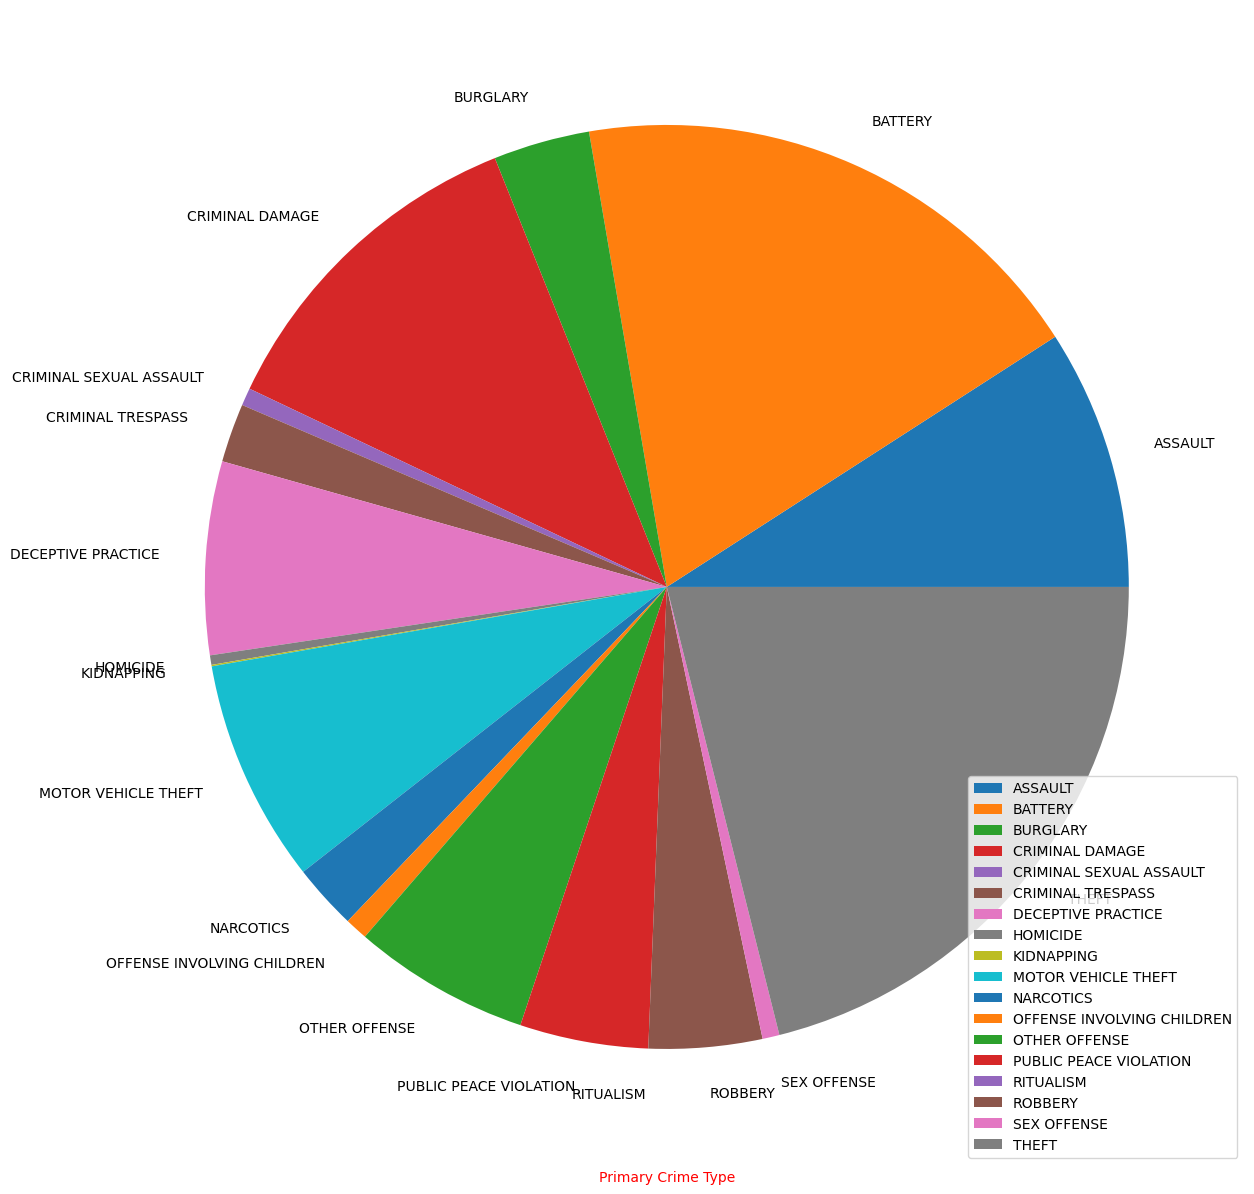

In [110]:
primaryVisualizeDF = data.groupby('Primary Type').size()
primaryVisualizeDF.plot.pie(figsize = (15,15))
plt.xlabel('Primary Crime Type', fontsize=10, color = 'red')
plt.legend()